# Box-Jenkins Method 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import math
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf ## ACF ans PACF
from pmdarima import auto_arima 

In [2]:
df = pd.read_csv('data/portland-oregon-average-monthly-.csv') 
df.sample(5)

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
55,1964-08,1044
31,1962-08,854
72,1966-01,1212
52,1964-05,1152
23,1961-12,761


I rename the average monthly bus ridership column, its name is clearly not relevant 

In [3]:
df.rename(columns={'Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114': 'ridership'}, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      115 non-null    object
 1   ridership  115 non-null    object
dtypes: object(2)
memory usage: 1.9+ KB


In [5]:
## let's find the reason why the second column is of type object 
df['ridership'].unique()

array(['648', '646', '639', '654', '630', '622', '617', '613', '661',
       '695', '690', '707', '817', '839', '810', '789', '760', '724',
       '704', '691', '745', '803', '780', '761', '857', '907', '873',
       '910', '900', '880', '867', '854', '928', '1064', '1103', '1026',
       '1102', '1080', '1034', '1083', '1078', '1020', '984', '952',
       '1033', '1114', '1160', '1058', '1209', '1200', '1130', '1182',
       '1152', '1116', '1098', '1044', '1142', '1222', '1234', '1155',
       '1286', '1281', '1224', '1280', '1228', '1181', '1156', '1124',
       '1205', '1260', '1188', '1212', '1269', '1246', '1299', '1284',
       '1345', '1341', '1308', '1448', '1454', '1467', '1431', '1510',
       '1558', '1536', '1523', '1492', '1437', '1365', '1310', '1441',
       '1450', '1424', '1360', '1429', '1440', '1414', '1408', '1337',
       '1258', '1214', '1326', '1417', '1329', '1461', '1425', '1419',
       '1432', '1394', '1327', ' n=114'], dtype=object)

We notice that the last unique observation is a bit strange, let's clean the data

In [6]:
df.drop(df.index[df['ridership'] == ' n=114'], inplace = True)
df['ridership'] = df['ridership'].astype('float64')
df['Month'] = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Month      114 non-null    datetime64[ns]
 1   ridership  114 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.7 KB


In [7]:
df.describe()

,ridership
count,114.000000
mean,1120.543860
std,270.888317
min,613.000000
25%,885.000000
50%,1158.000000
75%,1340.000000
max,1558.000000


## stationarity 

Let's first analyze the raw graph 

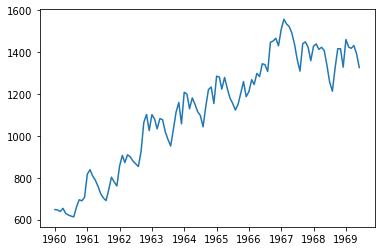

In [8]:
plt.plot(df['Month'], df['ridership']) 

<AxesSubplot:>

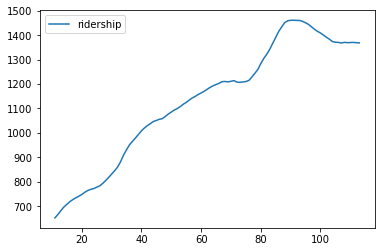

In [9]:
# Plot the data values with those of a moving average of order 12
MA_ridership =df[['ridership']]
MA_ridership.rolling(12).mean().plot()

It is clear that the series is not stationary, it presents an upward trend. 

Moreover, we notice a seasonality over time 

Let's analyze PACF and ACF

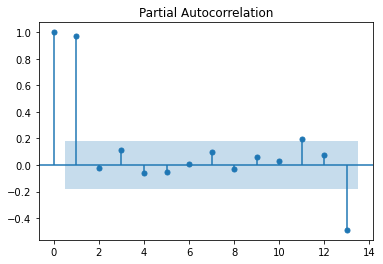

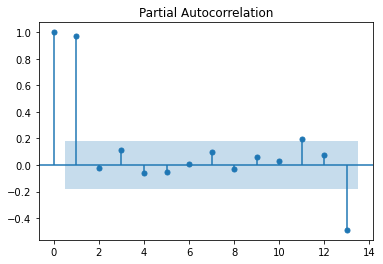

In [10]:
df = df.set_index('Month') ## avoid dimensionality problems 
plot_pacf(df,lags = 13)

It is clear that the first value is high, which suggests that for the AR part, the first coefficient is close to the unit root

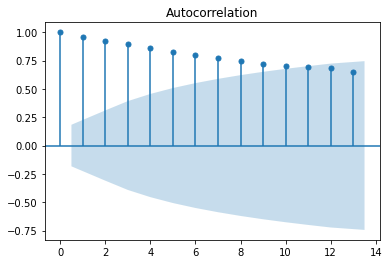

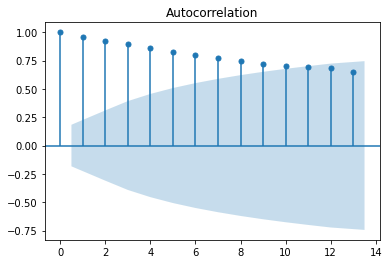

In [11]:
plot_acf(df,lags = 13)

We clearly notice a slow decay of the auto correlations as well as a persistence to the fall. 

This clearly suggests that the series is not stationary and that it must be differentiated 

In [60]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='green', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)

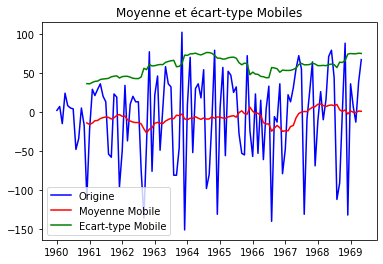

In [61]:
df_diff = df - df.shift(-1)
df_diff.dropna(inplace = True)
get_stationarity(df_diff)

Once the model is differentiated with d =1, we notice that the series is stationary around a zero mean 

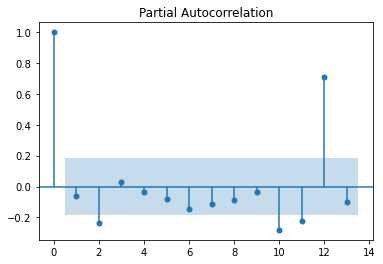

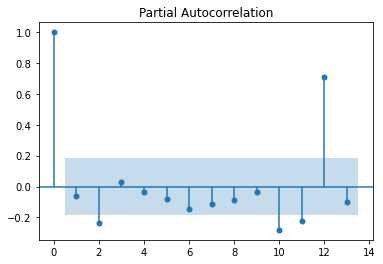

In [14]:
plot_pacf(df_diff,lags = 13)

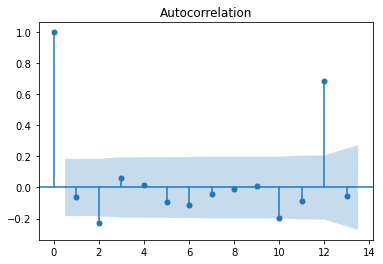

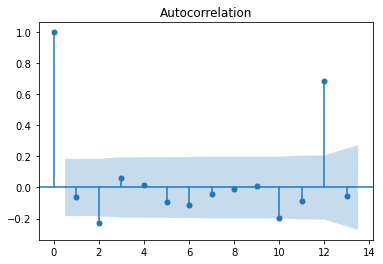

In [15]:
plot_acf(df_diff,lags = 13)

We notice that the model is stationary by simple differentiation. The rapid fall of the auto correlation and the first values not close to the unit root lead us to draw these consequences.

However, there is a clear seasonality with spikes at each t = 12. This seasonality is evidenced by the autocorrelogram at t=12

By operating a yearly sliding on our data, we obtain a stationary series that reduces seasonality 

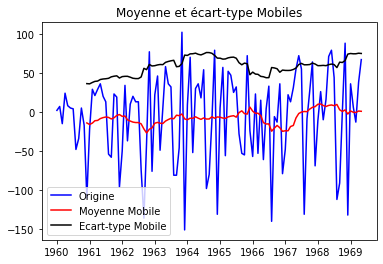

In [36]:
df_saeson = df - df.shift(-1) - df.shift(-12) + df.shift(-13) 
df_saeson.dropna(inplace = True)
get_stationarity(df_diff)

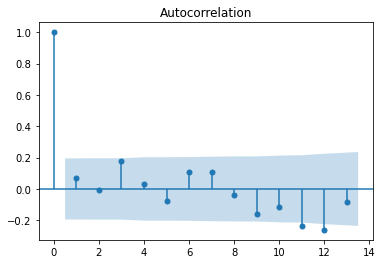

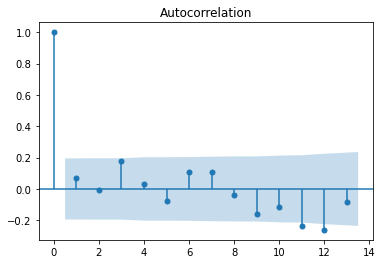

In [37]:
plot_acf(df_saeson,lags = 13)

No seasonality highlighted by the autocorrelogram 

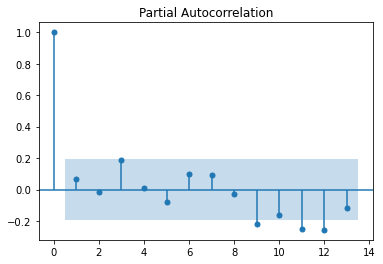

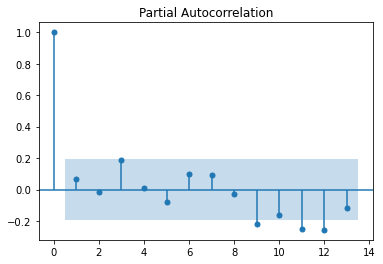

In [38]:
plot_pacf(df_saeson,lags = 13)

# Model

Performing stepwise search to minimize aic

In [39]:
stepwise_fit = auto_arima(df, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1235.799, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1236.989, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1238.600, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1238.277, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1236.254, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1234.903, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1233.580, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1235.475, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1234.436, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1232.849, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1234.568, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1236.809, Time=0.15 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1

In [53]:
import warnings
warnings.filterwarnings("ignore")
model = ARIMA(df , order = (1,1,3))
results_ARIMA = model.fit(disp = 1)

Compare the model to the original time series :

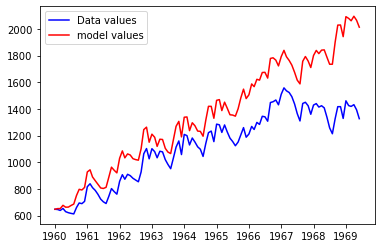

In [54]:
prediction_ARIMA = pd.Series(results_ARIMA.fittedvalues , copy = True)
prediction_ARIMA_cumsum = prediction_ARIMA.cumsum()

predictions_ARIMA = pd.Series(df['ridership'] , index = df.index )
predictions_ARIMA = predictions_ARIMA.add(prediction_ARIMA_cumsum , fill_value = 0)

Valeur = plt.plot(df, color = 'blue',label = 'Data values')
moyenne_mobile = plt.plot(predictions_ARIMA ,color = 'red',label = 'model values')
plt.legend(loc = 'best')

Finally we visualize the predictions :

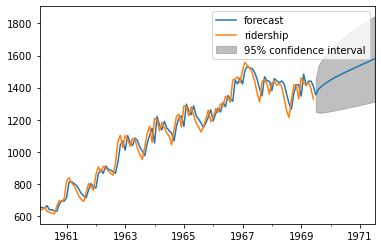

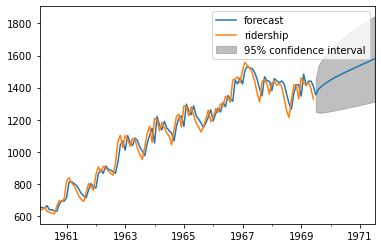

In [59]:
results_ARIMA.plot_predict(1,df.size + 24) 